# Prompt engineering on worst econ questions: answer verification, temperature, red/blue, context

In [1]:
%matplotlib inline

In [75]:
import pandas as pd
pd.set_option('display.max_columns', None)
from ollama_models import ollama_models
models = ollama_models()

In [76]:
models

['deepseek-r1:1.5b-qwen-distill-q4_K_M',
 'mistral-small3.2:24b-instruct-2506-q4_K_M']

In [78]:
model_mistral = models[1]

In [4]:
from community_alignment import community_alignment

Loaded existing index from forecast_index.faiss
Index contains 5839 vectors at initialization


100%|██████████████████████████████████████| 113/113 [00:00<00:00, 32691.15it/s]

saved community_deepseek-r1:1.5b-qwen-distill-q4_K_M.json


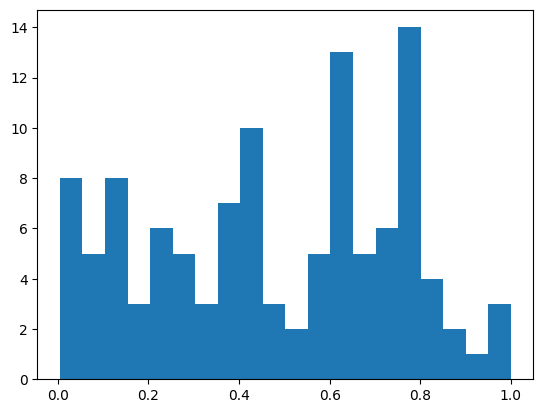

In [5]:
df = community_alignment(model)

In [6]:
from load_saved_questions import load_saved_questions
from call_local_llm import call_local_llm

In [7]:
question = load_saved_questions([4083])[0]

In [8]:
    from community_forecast import community_forecast
    import pandas as pd
    from flatten_dict import flatten_dict
    from datetime import datetime
    from gather_research_and_set_prompt import gather_research_and_set_prompt
    from generate_forecasts_and_update_rag import generate_forecasts_and_update_rag
    from tqdm import tqdm
    import time

In [9]:
    print('START model', model, 'id', id)
    start_time = time.time()
    questions = [question]
    id = question.id_of_question
    id_to_forecast = {question.id_of_question: community_forecast(question) for question in questions}
    df = pd.DataFrame([flatten_dict(q.api_json, sep='_') for q in questions])
    df['id_of_post'] = [q.id_of_post for q in questions]
    df['id_of_question'] = [q.id_of_question for q in questions]
    df['question_options'] = df['question_options'].apply(repr)
    df['today'] = datetime.now().strftime("%Y-%m-%d")
    df['crowd'] = df.apply(lambda row: id_to_forecast[row.id_of_question], axis=1)

START model deepseek-r1:1.5b-qwen-distill-q4_K_M id <built-in function id>


In [17]:
    df1 = df[['id_of_question', 'id_of_post', 'today', 'open_time', 'scheduled_resolve_time', 'title',
        'question_resolution_criteria', 'question_fine_print', 'question_type', 
         'question_description',
        'question_options', 'question_group_variable', 'question_question_weight',
        'question_unit', 'question_open_upper_bound', 'question_open_lower_bound',
        'question_scaling_range_max', 'question_scaling_range_min', 'question_scaling_zero_point','crowd']].copy()

In [18]:
    df2, rag = gather_research_and_set_prompt(df1, True, model)

Loaded existing index from forecast_index.faiss
Index contains 5839 vectors at initialization


In [43]:
df3 = df2[['id_of_question', 'title',
        'question_resolution_criteria', 'question_fine_print', 'question_type', 
         'question_description',
        'question_options', 'question_group_variable', 'question_question_weight',
        'question_unit', 'question_open_upper_bound', 'question_open_lower_bound',
        'question_scaling_range_max', 'question_scaling_range_min', 'question_scaling_zero_point','crowd',
          'research', 'asknews', 'learning']].copy()

In [48]:
row = df3.iloc[0]

In [132]:
row

id_of_question                                                               4083
title                           What will be the relative severity of the next...
question_resolution_criteria    This question will resolve as **Ambiguous** if...
question_fine_print                                                              
question_type                                                             numeric
question_description                                                             
question_options                                                             None
question_group_variable                                                          
question_question_weight                                                      1.0
question_unit                                                                    
question_open_upper_bound                                                    True
question_open_lower_bound                                                    True
question_scaling

In [ ]:
for item, value in row.items():
    print(item.upper())
    print()
    print(value)
    print('===============================')
    print()

In [ ]:
row.question_resolution_criteria

In [33]:
prompt = f"""Here is some information about a question:

TITLE
=====

{row.title}

RESOLUTION CRITERIA
===================

{row.question_resolution_criteria}

SCALE
=====

From {row.question_scaling_range_min} to {row.question_scaling_range_max}

Using the information, answer the following questions:

a.  What is the minimum value for the answer?
b.  What is the maximum value for the answer?
c.  Is there a formula for the answer given in the above text?
d.  If there is a formula, what needs to go into the formula and how do you estimate it?  Write a python function for the formula, commenting its inputs and outputs for clarity
"""

In [34]:
print(prompt)

Here is some information about a question:

TITLE
=====

What will be the relative severity of the next US depression, compared to the Great Depression?

RESOLUTION CRITERIA

This question will resolve as **Ambiguous** if there is no economic depression in the US between January 1, 2022 to January 1, 2032.  For this question, an "Economic Depression" is defined as meeting either of these criteria:

* A recession lasting for 36 months or longer (as adjudicated by [this Metaculus Question's resolution](https://www.metaculus.com/questions/2623/if-the-us-enters-a-recession-how-many-months-will-the-economic-contraction-last/)--i.e., if that one resolves ≥36, this criterion has been met).

* Any year's Annual Real GDP growth (as [reported by the US Bureau of Economic Analysis](https://www.bea.gov/news/current-releases)) is estimated to be -10% or less.

If such a depression occurs, the relative severity will be defined as the number of months the depression lasts times the real GDP decline i

In [35]:
terms = call_local_llm(prompt, model)

In [38]:
terms1 = terms.split("""</think>

""")[1])

In [79]:
terms_mistral = call_local_llm(prompt, model_mistral)

In [80]:
print(terms_mistral)

a. The minimum value for the answer is 0.1. This would occur if there is an economic depression with the shortest possible duration (just over 36 months) and the smallest possible real GDP decline (-10%).

b. The maximum value for the answer is 10.0. This would occur if there is an economic depression with the longest possible duration and the largest possible real GDP decline. However, the exact maximum is not specified, so 10.0 is the upper bound of the scale provided.

c. Yes, there is a formula for the answer given in the text. The relative severity is defined as:
\[ \text{Relative Severity} = \frac{\text{Number of months the depression lasts} \times \text{Real GDP decline in percentage points (peak to trough)}}{1131} \]

d. The formula requires two inputs:
1. The number of months the depression lasts.
2. The real GDP decline in percentage points (peak to trough).

These can be estimated using the resolution criteria provided:
- The number of months can be determined by the duratio

In [40]:
row.items

<bound method Series.items of id_of_question                                                               4083
title                           What will be the relative severity of the next...
question_resolution_criteria    This question will resolve as **Ambiguous** if...
question_fine_print                                                              
question_type                                                             numeric
question_description                                                             
question_options                                                             None
question_group_variable                                                          
question_question_weight                                                      1.0
question_unit                                                                    
question_open_upper_bound                                                    True
question_open_lower_bound                                           

In [39]:
print(terms1)

**Answer:**

a. **Minimum Value:** 0.1  
   - The minimum relative severity is set to 0.1 to ensure clarity in interpretation.

b. **Maximum Value:** Approximately 9.4  
   - This aligns with the Great Depression's calculated value, providing a reasonable upper bound for subsequent depressions.

c. **Formula:**  
   \[
   \text{Relative Severity} = \frac{\text{Duration (months)} \times \text{Real GDP Decline (\%)}}
   \]
   
d. **Python Function:**

```python
def calculate_relativeness(duration_months, real_gdp_decline):
    severity = (duration_months * real_gdp_decline) / 1131
    return round(severity, 2)
```

**Inputs and Outputs:**  
- **Duration Months:** Number of months the depression lasts.  
- **Real GDP Decline (%):** Percentage point reduction in annual real GDP.  

This function computes the relative severity using the provided formula.


In [89]:
prompt2 = f"""
You are the intelligence community's best geopolitical, economic and overall news trivia forecaster.  
You are given the following information to make a prediction:

```title
{row.title}
```

```news
{row.asknews}

```research
{row.research}
```

Using the title, news and research, make a forecast according to the formulas you derived in the previous prompt response.
If the Python function has multiple variables, assess each variable individually and then use the function to compute the measure.

The last thing you write is your final answer as this sequence of percentile levels in percent and values as floating point numbers without currency symbols, commas or spelled out numbers like "trillion", just the raw complete number:
"
Percentile 10: XX
Percentile 20: XX
Percentile 40: XX
Percentile 60: XX
Percentile 80: XX
Percentile 90: XX
"
Each line of the final answer MUST START with the word "Percentile".  For example if you have "10: 201" instead of "Percentile 10: 201", that is wrong.

PLEASE REMEMBER THAT THE ANSWER MUST BE IN THE TERMS REQUESTED BY THE PROBLEM.  
A QUICK CORRECTNESS CHECK IS THAT YOUR ANSWER MUST LIE BETWEEN THE MINIMUM AND MAXIMUM VALUES SPECIFIED.  
THE REQUESTED TERMS ARE AS FOLLOWS:

```terms
{terms_mistral}
```
"""

In [90]:
print(prompt2)


You are the intelligence community's best geopolitical, economic and overall news trivia forecaster.  
You are given the following information to make a prediction:

```title
What will be the relative severity of the next US depression, compared to the Great Depression?
```

```news
Here are the relevant news articles:

**The Worsening Pandemic of Gambling Highlighted in the Journal of American Physicians and Surgeons**
Gambling addiction is worse than substance abuse in many ways, including higher suicide rates, according to Andrew Schlafly, Esq. in the Journal of American Physicians and Surgeons. A Swedish study found that the rate of suicide is 15 times higher among gamblers than in the general population. Physical health problems and psychiatric harm are also common among gamblers, including hypertension, cardiovascular disease, and major depressive episodes. Roughly half of Americans are engaged in gambling, and extreme addiction afflicts about 5% of the population. Schlafly warn

In [91]:
answer_mistral = call_local_llm(prompt2, model_mistral)

In [ ]:
answer_mistral2 = call_local_llm(prompt2, model_mistral)

In [97]:
answer_mistral3 = call_local_llm(prompt2, model_mistral)

START model mistral-small3.2:24b-instruct-2506-q4_K_M id 4083
model mistral-small3.2:24b-instruct-2506-q4_K_M id 4083 minutes 5.391960394382477


In [101]:
from extract_forecast import extract_percentile_numbers

In [103]:
forecasts = [extract_percentile_numbers(x) for x in [answer_mistral, answer_mistral2, answer_mistral3]]

In [104]:
forecasts

[{10: 0.32, 20: 0.38, 40: 0.49, 60: 0.69, 80: 0.87, 90: 1.06},
 {10: 0.32, 20: 0.37, 40: 0.52, 60: 0.67, 80: 0.78, 90: 0.85},
 {10: 0.32, 20: 0.35, 40: 0.43, 60: 0.7, 80: 0.8, 90: 0.85}]

In [105]:
from median_dictionaries import median_dictionaries

In [106]:
forecast = median_dictionaries(forecasts)

In [107]:
forecast

{10: 0.32, 20: 0.37, 40: 0.49, 60: 0.69, 80: 0.8, 90: 0.85}

In [121]:
prompt = f"""
Summarize the gist pf the rationale or thinking of the following answers from 3 different forecasters to a single problem. 

```forecast 1
{answer_mistral}
```

```forecast 2
{answer_mistral2}
```

```forecast 3
{answer_mistral3}
```

DO NOT REFER TO THE 3 FORECASTERS.  PRESENT THIS AS YOUR OWN THINKING, YOUR OWN RATIONALE.  Use as your final the median forecast which is

```median forecast
{forecast}
```
"""

In [124]:
rationale = call_local_llm(prompt, model_mistral)

START model mistral-small3.2:24b-instruct-2506-q4_K_M
model mistral-small3.2:24b-instruct-2506-q4_K_M minutes 4.024289488792419


In [125]:
print(rationale)

To forecast the potential severity of a US depression between 2022 and 2032, I analyzed key variables—depression duration and real GDP decline—using available news articles and research. The goal was to estimate the relative severity at various percentiles based on these variables.

### Key Variables and Estimates

1. **Depression Duration (months)**:
   - Historical context suggests depressions typically last 3-4 years (36-48 months), but some forecasts suggest longer durations.
   - Estimated range: 36 to 48 months.

2. **Real GDP Decline (%)**:
   - The Great Depression saw a 26.3% decline, but modern economies have stronger safeguards.
   - Forecasts suggest a potential decline of 10-20% in a severe depression scenario.
   - Estimated range: 10 to 20%.

### Percentile Estimates

I estimated the relative severity at various percentiles based on the range of possible outcomes:

1. **Percentile 10 (Optimistic Scenario)**:
   - Duration: 36 months
   - GDP Decline: 10%
   - Relative Se

In [127]:
row.forecast = rationale

In [128]:
row.prediction = forecast

In [129]:
row.crowd

{10: 0.12078030935394252,
 20: 0.18090452838404858,
 40: 0.31602166092352635,
 60: 0.5855876413475696,
 80: 1.08827192521814,
 90: 2.0153375155147737}

In [130]:
from error import error

In [131]:
error(row)

0.4977514933466121